In [4]:
import numpy as np
import struct

def load_images(file_path):
    with open(file_path, 'rb') as file:
        cool, num_images, height, width = struct.unpack(">IIII", file.read(16))
        images = np.fromfile(file, dtype=np.uint8).reshape(num_images, height * width) / 255.0
    return images

def load_labels(file_path):
    with open(file_path, 'rb') as file:
        cool, num_labels = struct.unpack(">II", file.read(8))
        labels = np.fromfile(file, dtype=np.uint8)
    return labels

def convert_to_one_hot(labels, classes=10):
    return np.eye(classes)[labels]

train_images = load_images('C:/Users/A13na/OneDrive/Desktop/ASS1/train-images.idx3-ubyte')
train_labels = load_labels('C:/Users/A13na/OneDrive/Desktop/ASS1/train-labels.idx1-ubyte')
test_images = load_images('C:/Users/A13na/OneDrive/Desktop/ASS1/t10k-images.idx3-ubyte')
test_labels = load_labels('C:/Users/A13na/OneDrive/Desktop/ASS1/t10k-labels.idx1-ubyte')

train_labels = convert_to_one_hot(train_labels)
test_labels = convert_to_one_hot(test_labels)


In [5]:
import pickle
import os
from sklearn.model_selection import train_test_split

class NeuralNetwork:
    def __init__(self, N, layer_sizes, lr, activation_func,weight_init, epochs=100, batch_size=128):
        self.N = N 
        self.layer_sizes = layer_sizes
        self.lr = lr
        self.activation_func = activation_func
        self.weight_init = weight_init
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = self.create_weights()
        self.biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(N - 1)] 
    
    def create_weights(self):
        matrices = []
        for idx in range(1, len(self.layer_sizes)):
            if self.weight_init == 'zero':
                matrix = np.zeros((self.layer_sizes[idx], self.layer_sizes[idx-1]))
            elif self.weight_init == 'random':
                matrix = np.random.rand(self.layer_sizes[idx], self.layer_sizes[idx-1]) * 0.01
            elif self.weight_init == 'normal':
                matrix = np.random.randn(self.layer_sizes[idx], self.layer_sizes[idx-1]) * np.sqrt(2 / self.layer_sizes[idx-1])
            matrices.append(matrix)
        return matrices


    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def sigmoid_derivative(self, Z):
        s = self.sigmoid(Z)
        return s * (1 - s)

    def tanh(self, Z):
        return np.tanh(Z)

    def tanh_derivative(self, Z):
        return 1 - np.tanh(Z) ** 2

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return Z > 0

    def leaky_relu(self, Z, alpha=0.01):
        return np.where(Z > 0, Z, alpha * Z)

    def leaky_relu_derivative(self, Z, alpha=0.1):
        dZ = np.ones_like(Z)
        dZ[Z < 0] = alpha
        return dZ

    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return expZ / expZ.sum(axis=1, keepdims=True)

    def forward(self, X):
        activations = [X]
        for i in range(self.N - 1):
            X = X @ self.weights[i].T + self.biases[i]
            
            if i < self.N - 2:  
                if self.activation_func == 'relu':
                    X = self.relu(X)
                elif self.activation_func == 'sigmoid':
                    X = self.sigmoid(X)
                elif self.activation_func == 'tanh':
                    X = self.tanh(X)
                elif self.activation_func == 'leaky_relu':
                    X = self.leaky_relu(X)
            else:  
                X = self.softmax(X)
            activations.append(X)
        return activations

    def backpropagation(self, activations, X, Y):
        m = X.shape[0]
        dA = activations[-1] - Y
        dWs = []
        dBs= []

        for i in reversed(range(self.N-1)):
            dW = (dA.T @ activations[i]) / m
            dB = np.sum(dA, axis=0, keepdims=True) / m

            dWs.insert(0, dW)
            dBs.insert(0, dB)  

            if self.activation_func == 'relu':
                der = self.relu_derivative(activations[i])
            elif self.activation_func == 'sigmoid':
                der = self.sigmoid_derivative(activations[i])
            elif self.activation_func == 'tanh':
                der = self.tanh_derivative(activations[i])
            elif self.activation_func == 'leaky_relu':
                der = self.leaky_relu_derivative(activations[i])

            if i > 0:
               dA = (dA @ self.weights[i]) * der           

        return dWs,dBs

    def update_weights(self, dWs, dBs):
        for i in range(self.N-1):
            self.weights[i] -= self.lr * dWs[i]
            self.biases[i] -= self.lr* dBs[i]

    def fit(self, X, Y, X_val=None, Y_val=None):
        self.history = {'train_loss': [], 'val_loss': []}

        for epoch in range(self.epochs):
            
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X, Y = X[indices], Y[indices]

            
            for start in range(0, X.shape[0], self.batch_size):
                end = start + self.batch_size
                X_batch, Y_batch = X[start:end], Y[start:end]

                
                activations = self.forward(X_batch)

                
                dWs, dBs = self.backpropagation(activations, X_batch, Y_batch)

                
                self.update_weights(dWs, dBs)

            
            train_loss = self.compute_loss(X, Y)
            self.history['train_loss'].append(train_loss)

            
            if X_val is not None and Y_val is not None:
                val_loss = self.compute_loss(X_val, Y_val)
                self.history['val_loss'].append(val_loss)

            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{self.epochs} - Train Loss: {train_loss:.6f}")
                print(f"Accuracy on train set: {self.score(X, Y)}")
                if X_val is not None and Y_val is not None:
                    print(f"Validation Loss: {val_loss:.6f}")

    def compute_loss(self, X, Y):
        activations = self.forward(X)
        predictions = activations[-1]
        return -np.mean(Y * np.log(predictions + 1e-8))

    def predict_proba(self, X):
        activations= self.forward(X)
        return activations[-1]

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def score(self, X, Y):
        predictions = self.predict(X)
        true_labels = np.argmax(Y, axis=1)
        return np.mean(predictions == true_labels)

Model with sigmoid activation and zero initialization already exists. Loading the model...


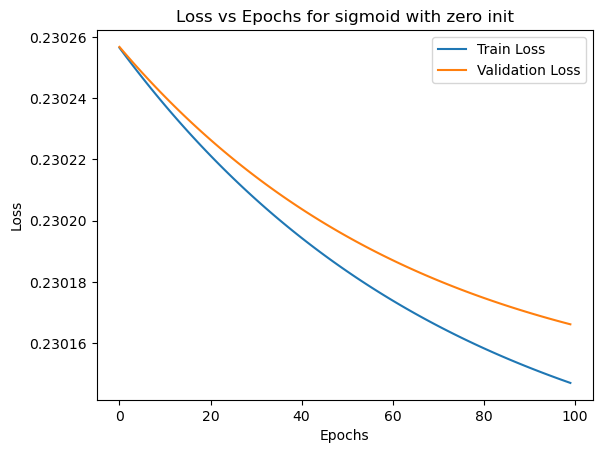

Model with sigmoid activation and random initialization already exists. Loading the model...


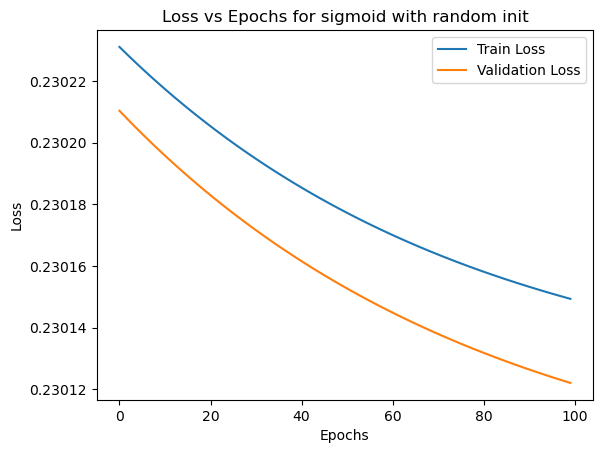

Model with sigmoid activation and normal initialization already exists. Loading the model...


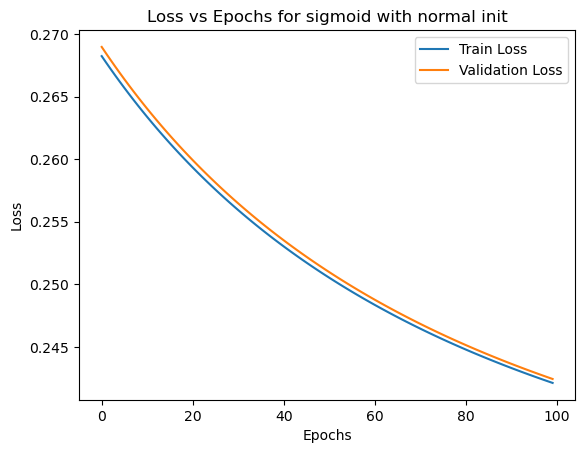

Training model with tanh activation and zero initialization...
Epoch 10/100 - Train Loss: 0.230256
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230257
Epoch 20/100 - Train Loss: 0.230254
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230255
Epoch 30/100 - Train Loss: 0.230252
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230253
Epoch 40/100 - Train Loss: 0.230250
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230251
Epoch 50/100 - Train Loss: 0.230248
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230249
Epoch 60/100 - Train Loss: 0.230245
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230247
Epoch 70/100 - Train Loss: 0.230243
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230245
Epoch 80/100 - Train Loss: 0.230241
Accuracy on train set: 0.11291666666666667
Validation Loss: 0.230244
Epoch 90/100 - Train Loss: 0.230239
Accuracy on train set: 0.11291666666666667
Validation Loss: 0

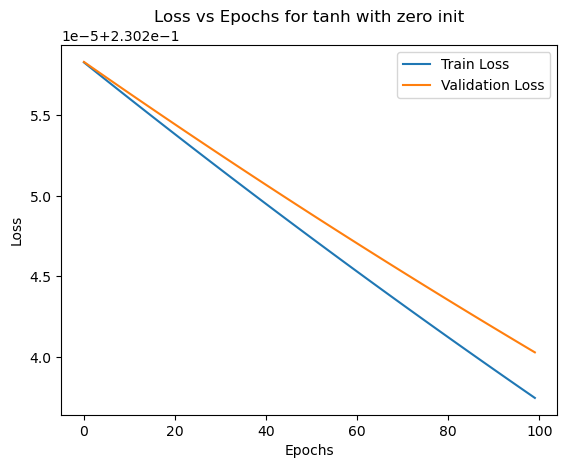

Training model with tanh activation and random initialization...
Epoch 10/100 - Train Loss: 0.230248
Accuracy on train set: 0.09934895833333333
Validation Loss: 0.230248
Epoch 20/100 - Train Loss: 0.230244
Accuracy on train set: 0.099453125
Validation Loss: 0.230244
Epoch 30/100 - Train Loss: 0.230240
Accuracy on train set: 0.10239583333333334
Validation Loss: 0.230240
Epoch 40/100 - Train Loss: 0.230236
Accuracy on train set: 0.115234375
Validation Loss: 0.230236
Epoch 50/100 - Train Loss: 0.230232
Accuracy on train set: 0.13455729166666666
Validation Loss: 0.230231
Epoch 60/100 - Train Loss: 0.230228
Accuracy on train set: 0.16231770833333334
Validation Loss: 0.230227
Epoch 70/100 - Train Loss: 0.230224
Accuracy on train set: 0.16651041666666666
Validation Loss: 0.230223
Epoch 80/100 - Train Loss: 0.230220
Accuracy on train set: 0.17372395833333334
Validation Loss: 0.230219
Epoch 90/100 - Train Loss: 0.230216
Accuracy on train set: 0.17885416666666668
Validation Loss: 0.230215
Epoch 

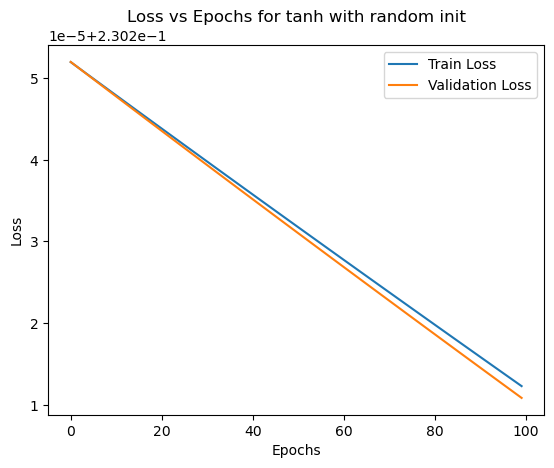

Training model with tanh activation and normal initialization...
Epoch 10/100 - Train Loss: 0.215144
Accuracy on train set: 0.2633463541666667
Validation Loss: 0.216617
Epoch 20/100 - Train Loss: 0.197362
Accuracy on train set: 0.36591796875
Validation Loss: 0.198524
Epoch 30/100 - Train Loss: 0.183171
Accuracy on train set: 0.4365234375
Validation Loss: 0.184053
Epoch 40/100 - Train Loss: 0.171541
Accuracy on train set: 0.48466796875
Validation Loss: 0.172182
Epoch 50/100 - Train Loss: 0.161838
Accuracy on train set: 0.5198893229166667
Validation Loss: 0.162277
Epoch 60/100 - Train Loss: 0.153631
Accuracy on train set: 0.5492838541666667
Validation Loss: 0.153904
Epoch 70/100 - Train Loss: 0.146605
Accuracy on train set: 0.57490234375
Validation Loss: 0.146741
Epoch 80/100 - Train Loss: 0.140519
Accuracy on train set: 0.5970377604166667
Validation Loss: 0.140543
Epoch 90/100 - Train Loss: 0.135190
Accuracy on train set: 0.6190755208333333
Validation Loss: 0.135122
Epoch 100/100 - Trai

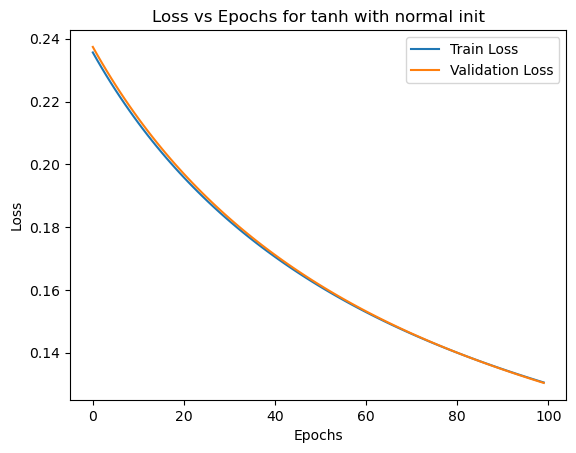

Training model with relu activation and zero initialization...
Epoch 10/100 - Train Loss: 0.230257
Accuracy on train set: 0.112548828125
Validation Loss: 0.230258
Epoch 20/100 - Train Loss: 0.230256
Accuracy on train set: 0.112548828125
Validation Loss: 0.230257
Epoch 30/100 - Train Loss: 0.230255
Accuracy on train set: 0.112548828125
Validation Loss: 0.230256
Epoch 40/100 - Train Loss: 0.230254
Accuracy on train set: 0.112548828125
Validation Loss: 0.230255
Epoch 50/100 - Train Loss: 0.230253
Accuracy on train set: 0.112548828125
Validation Loss: 0.230254
Epoch 60/100 - Train Loss: 0.230252
Accuracy on train set: 0.112548828125
Validation Loss: 0.230253
Epoch 70/100 - Train Loss: 0.230251
Accuracy on train set: 0.112548828125
Validation Loss: 0.230252
Epoch 80/100 - Train Loss: 0.230250
Accuracy on train set: 0.112548828125
Validation Loss: 0.230251
Epoch 90/100 - Train Loss: 0.230249
Accuracy on train set: 0.112548828125
Validation Loss: 0.230250
Epoch 100/100 - Train Loss: 0.230248


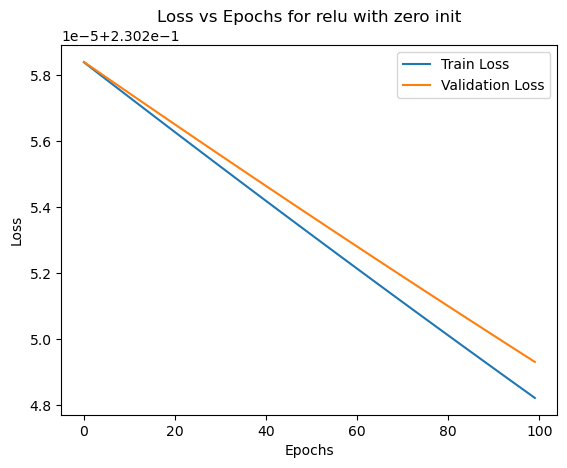

Training model with relu activation and random initialization...
Epoch 10/100 - Train Loss: 0.230239
Accuracy on train set: 0.10198372329603256
Validation Loss: 0.230246
Epoch 20/100 - Train Loss: 0.230233
Accuracy on train set: 0.10198372329603256
Validation Loss: 0.230240
Epoch 30/100 - Train Loss: 0.230227
Accuracy on train set: 0.1020854526958291
Validation Loss: 0.230234
Epoch 40/100 - Train Loss: 0.230221
Accuracy on train set: 0.10269582909460834
Validation Loss: 0.230229
Epoch 50/100 - Train Loss: 0.230214
Accuracy on train set: 0.10437436419125128
Validation Loss: 0.230223
Epoch 60/100 - Train Loss: 0.230208
Accuracy on train set: 0.10223804679552391
Validation Loss: 0.230218
Epoch 70/100 - Train Loss: 0.230202
Accuracy on train set: 0.10279755849440489
Validation Loss: 0.230212
Epoch 80/100 - Train Loss: 0.230196
Accuracy on train set: 0.10315361139369278
Validation Loss: 0.230207
Epoch 90/100 - Train Loss: 0.230190
Accuracy on train set: 0.10366225839267548
Validation Loss: 

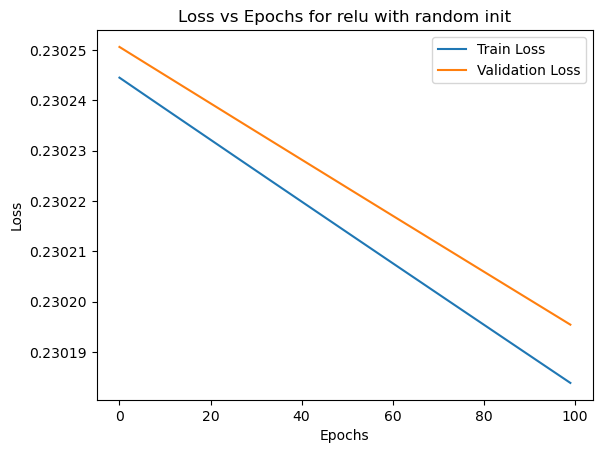

Training model with relu activation and normal initialization...
Epoch 10/100 - Train Loss: 0.238239
Accuracy on train set: 0.15068667344862666
Validation Loss: 0.238215
Epoch 20/100 - Train Loss: 0.235207
Accuracy on train set: 0.15927009155645983
Validation Loss: 0.235157
Epoch 30/100 - Train Loss: 0.232963
Accuracy on train set: 0.16531027466937945
Validation Loss: 0.232904
Epoch 40/100 - Train Loss: 0.231175
Accuracy on train set: 0.1728763987792472
Validation Loss: 0.231123
Epoch 50/100 - Train Loss: 0.229671
Accuracy on train set: 0.18177772126144456
Validation Loss: 0.229638
Epoch 60/100 - Train Loss: 0.228363
Accuracy on train set: 0.1893438453713123
Validation Loss: 0.228356
Epoch 70/100 - Train Loss: 0.227192
Accuracy on train set: 0.1963377416073245
Validation Loss: 0.227212
Epoch 80/100 - Train Loss: 0.226104
Accuracy on train set: 0.20536622583926756
Validation Loss: 0.226155
Epoch 90/100 - Train Loss: 0.225069
Accuracy on train set: 0.2132502543234995
Validation Loss: 0.2

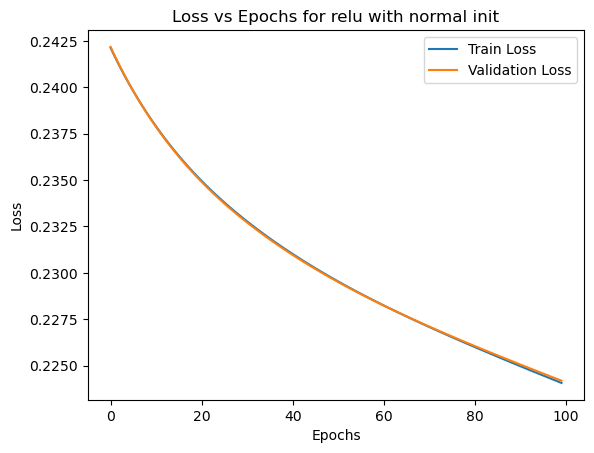

Training model with leaky_relu activation and zero initialization...
Epoch 10/100 - Train Loss: 0.230258
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230258
Epoch 20/100 - Train Loss: 0.230257
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230257
Epoch 30/100 - Train Loss: 0.230257
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230257
Epoch 40/100 - Train Loss: 0.230256
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230256
Epoch 50/100 - Train Loss: 0.230256
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230256
Epoch 60/100 - Train Loss: 0.230255
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230255
Epoch 70/100 - Train Loss: 0.230255
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230255
Epoch 80/100 - Train Loss: 0.230254
Accuracy on train set: 0.11055476076935304
Validation Loss: 0.230254
Epoch 90/100 - Train Loss: 0.230254
Accuracy on train set: 0.11055476076935304
Validation L

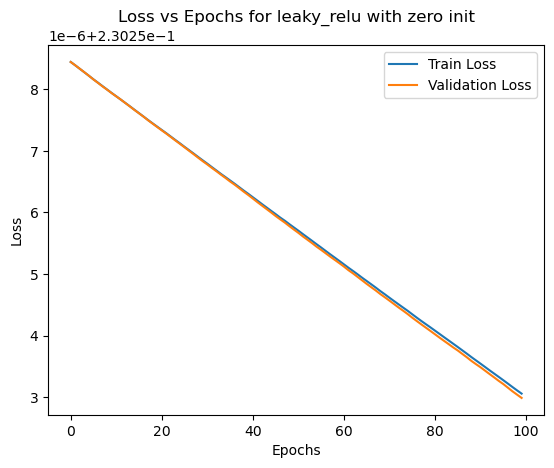

Training model with leaky_relu activation and random initialization...
Epoch 10/100 - Train Loss: 0.230269
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230268
Epoch 20/100 - Train Loss: 0.230266
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230265
Epoch 30/100 - Train Loss: 0.230263
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230262
Epoch 40/100 - Train Loss: 0.230260
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230258
Epoch 50/100 - Train Loss: 0.230256
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230255
Epoch 60/100 - Train Loss: 0.230253
Accuracy on train set: 0.09836065573770492
Validation Loss: 0.230252
Epoch 70/100 - Train Loss: 0.230250
Accuracy on train set: 0.09846000993541977
Validation Loss: 0.230249
Epoch 80/100 - Train Loss: 0.230247
Accuracy on train set: 0.0990561351217089
Validation Loss: 0.230246
Epoch 90/100 - Train Loss: 0.230244
Accuracy on train set: 0.09985096870342772
Validation 

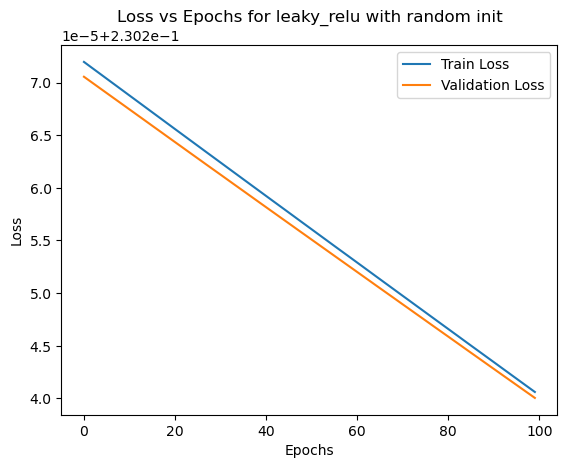

Training model with leaky_relu activation and normal initialization...
Epoch 10/100 - Train Loss: 0.234738
Accuracy on train set: 0.08507203179334327
Validation Loss: 0.234507
Epoch 20/100 - Train Loss: 0.233262
Accuracy on train set: 0.0868107302533532
Validation Loss: 0.233064
Epoch 30/100 - Train Loss: 0.231910
Accuracy on train set: 0.08991554893194237
Validation Loss: 0.231739
Epoch 40/100 - Train Loss: 0.230654
Accuracy on train set: 0.09165424739195231
Validation Loss: 0.230506
Epoch 50/100 - Train Loss: 0.229466
Accuracy on train set: 0.09848484848484848
Validation Loss: 0.229336
Epoch 60/100 - Train Loss: 0.228339
Accuracy on train set: 0.10481867858917039
Validation Loss: 0.228227
Epoch 70/100 - Train Loss: 0.227265
Accuracy on train set: 0.111525086934923
Validation Loss: 0.227170
Epoch 80/100 - Train Loss: 0.226235
Accuracy on train set: 0.11934923000496771
Validation Loss: 0.226155
Epoch 90/100 - Train Loss: 0.225239
Accuracy on train set: 0.1290362642821659
Validation Los

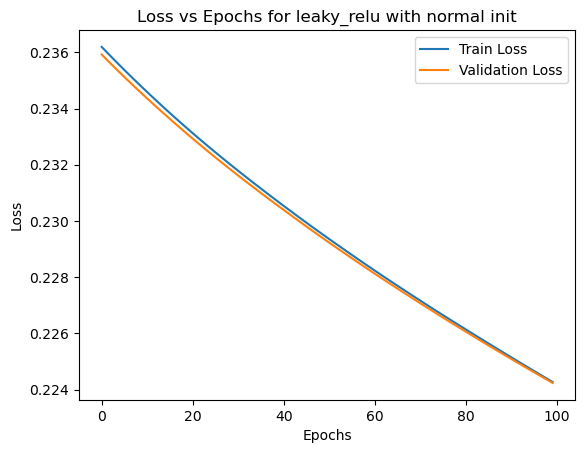

In [6]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
initializations = ['zero', 'random', 'normal']
results = {}


for activation in activations:
    for init in initializations:
        model_filename = f"model_{activation}_{init}.pkl"
        
        
        if os.path.exists(model_filename):
            print(f"Model with {activation} activation and {init} initialization already exists. Loading the model...")
            
            
            with open(model_filename, 'rb') as f:
                model = pickle.load(f)
            
            
            plt.plot(range(len(model.history['train_loss'])), model.history['train_loss'], label="Train Loss")
            plt.plot(range(len(model.history['val_loss'])), model.history['val_loss'], label="Validation Loss")
            plt.title(f"Loss vs Epochs for {activation} with {init} init")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

        else:
            print(f"Training model with {activation} activation and {init} initialization...")

            
            model = NeuralNetwork(
                N=6,
                layer_sizes=[784, 256, 128, 64, 32, 10],
                lr=2e-5,
                activation_func=activation,
                weight_init=init,
                epochs=100,
                batch_size=128,
            )
            
            
            train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

            
            model.fit(train_images, train_labels, X_val=val_images, Y_val=val_labels)

            
            with open(model_filename, 'wb') as f:
                pickle.dump(model, f)

            
            train_loss = model.compute_loss(train_images, train_labels)
            val_loss = model.compute_loss(val_images, val_labels)
            results[f"{activation}_{init}"] = (train_loss, val_loss)

            
            plt.plot(range(len(model.history['train_loss'])), model.history['train_loss'], label="Train Loss")
            plt.plot(range(len(model.history['val_loss'])), model.history['val_loss'], label="Validation Loss")
            plt.title(f"Loss vs Epochs for {activation} with {init} init")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
